In [435]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from IPython.display import clear_output

In [436]:
class Q_Learning:
    def __init__(self, learning_rate, discount_factor, exploration_factor, epochs_limit):
        self.env = gym.make('Taxi-v3').env
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_factor
        self.epsilons_history = []
        self.min_epsilon = 0.01
        self.max_epsilon = 1
        self.decay = 0.01
        self.learning_epochs_limit = epochs_limit

        self.q_table = np.zeros([self.env.observation_space.n, self.env.action_space.n])
        self.points_during_learning = []

    def learn(self):
        rng = np.random.default_rng()
        for i in range(self.learning_epochs_limit):
            # initialize
            state = self.env.reset()
            done = False

            points = 0
            while not done:
                # choose an action
                if rng.uniform(0, 1) < self.epsilon:
                    action = self.env.action_space.sample()
                else:
                    action = np.argmax(self.q_table[state])
                # make new step
                next_state, reward, done, info = self.env.step(action)
                points += reward
                # update q_table
                old_q = self.q_table[state, action]
                next_max_q = np.max(self.q_table[next_state])
                new_q = (1 - self.alpha) * old_q + self.alpha * (reward + self.gamma * next_max_q)
                self.q_table[state, action] = new_q
                state = next_state
            # exploration factor decreases with time
            self.update_epsilon(i)
            self.points_during_learning.append(points)
        print("Training finished.\n")

    def plot_learning_process(self):
        x = range(self.learning_epochs_limit)
        plt.figure(figsize=(30, 10))
        plt.plot(x, self.points_during_learning)
        plt.ylim(-500, 50)
        plt.xlabel('Epoch')
        plt.ylabel('Training total points')
        plt.title('Total points over all epochs in training')
        plt.grid(visible=True)
        plt.show()

    def plot_epsilons(self):
        plt.figure(figsize=(30, 10))
        plt.plot(self.epsilons_history)
        plt.xlabel('Epoch')
        plt.ylabel('Epsilon')
        plt.title("Epsilon for epoch")
        plt.grid(visible=True)
        plt.show()

    def show_map(self, start_point, max_step_limit, with_training):
        state = self.env.encode(start_point[0], start_point[1], start_point[2], start_point[3])
        self.env.s = state
        self.env.render()
        frames = []
        done = False
        moves_limit = 0
        while not (done or moves_limit == max_step_limit):
            if with_training:
                action = np.argmax(self.q_table[state])
            else:
                action = self.env.action_space.sample()

            state, reward, done, info = self.env.step(action)
            frames.append({
                'frame': self.env.render(mode='ansi'),
                'state': state,
                'action': action,
                'reward': reward
            })
            moves_limit += 1
        self.print_frames(frames)

    def evaluate(self, evaluations_number, with_training):
        total_epochs, total_points = 0, 0
        for _ in range(evaluations_number):
            state = self.env.reset()
            epochs, points = 0, 0
            done = False
            while not done:
                if with_training:
                    action = np.argmax(self.q_table[state])
                else:
                    action = self.env.action_space.sample()

                state, reward, done, info = self.env.step(action)
                epochs += 1
                points += reward

            total_epochs += epochs
            total_points += points

        print(f"After {evaluations_number} evaluations:")
        print(f"Average time steps to finish: {int(total_epochs / evaluations_number)}")
        print(f"Average points per epoch: {int(total_points / evaluations_number)}")

    def print_frames(self, frames):
        for i, frame in enumerate(frames):
            clear_output(wait=True)
            print(frame['frame'])
            print(f"Timestep: {i + 1}")
            print(f"State: {frame['state']}")
            print(f"Action: {frame['action']}")
            print(f"Reward: {frame['reward']}")
            sleep(.5)

    def update_epsilon(self, episode):
        self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-self.decay * episode)
        self.epsilons_history.append(self.epsilon)

In [437]:
q_learning_1 = Q_Learning(0.5, 0.6, 1, 1000)

In [438]:
q_learning_1.learn()

Training finished.



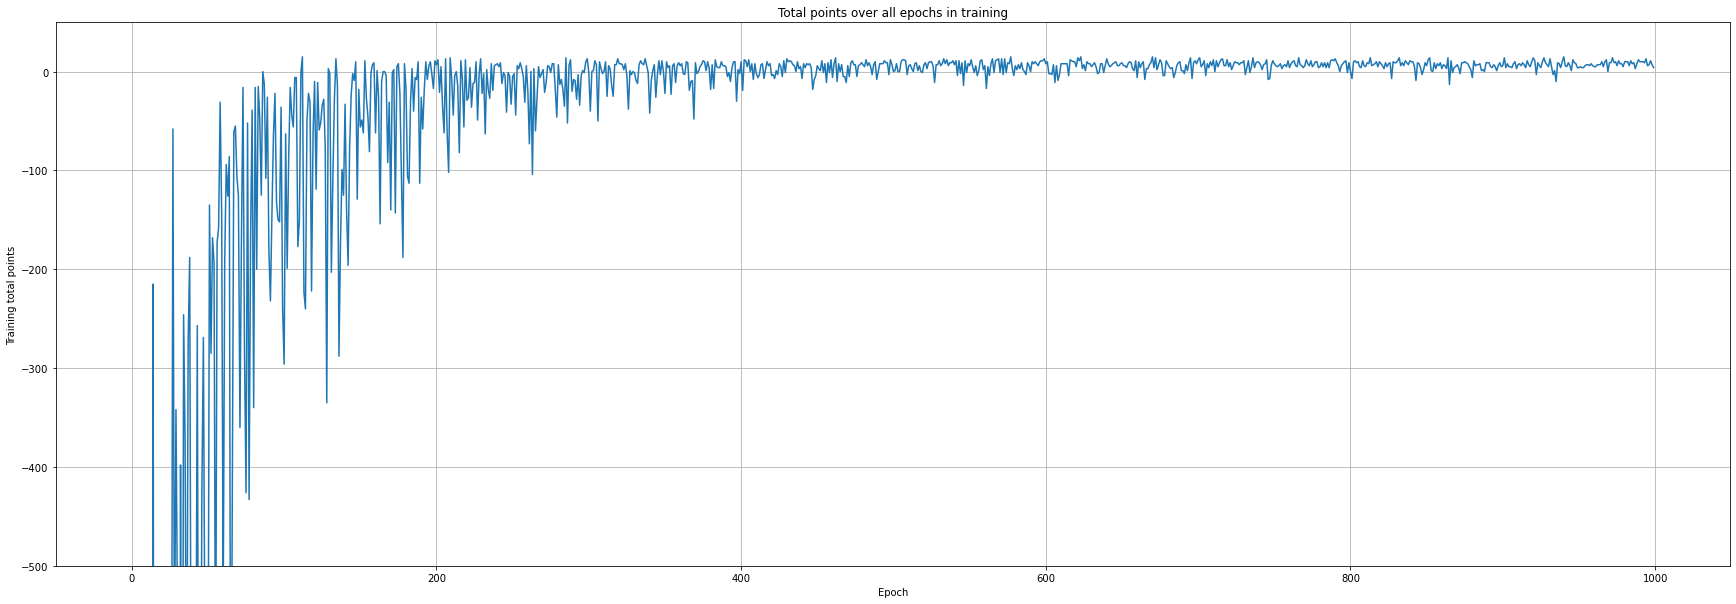

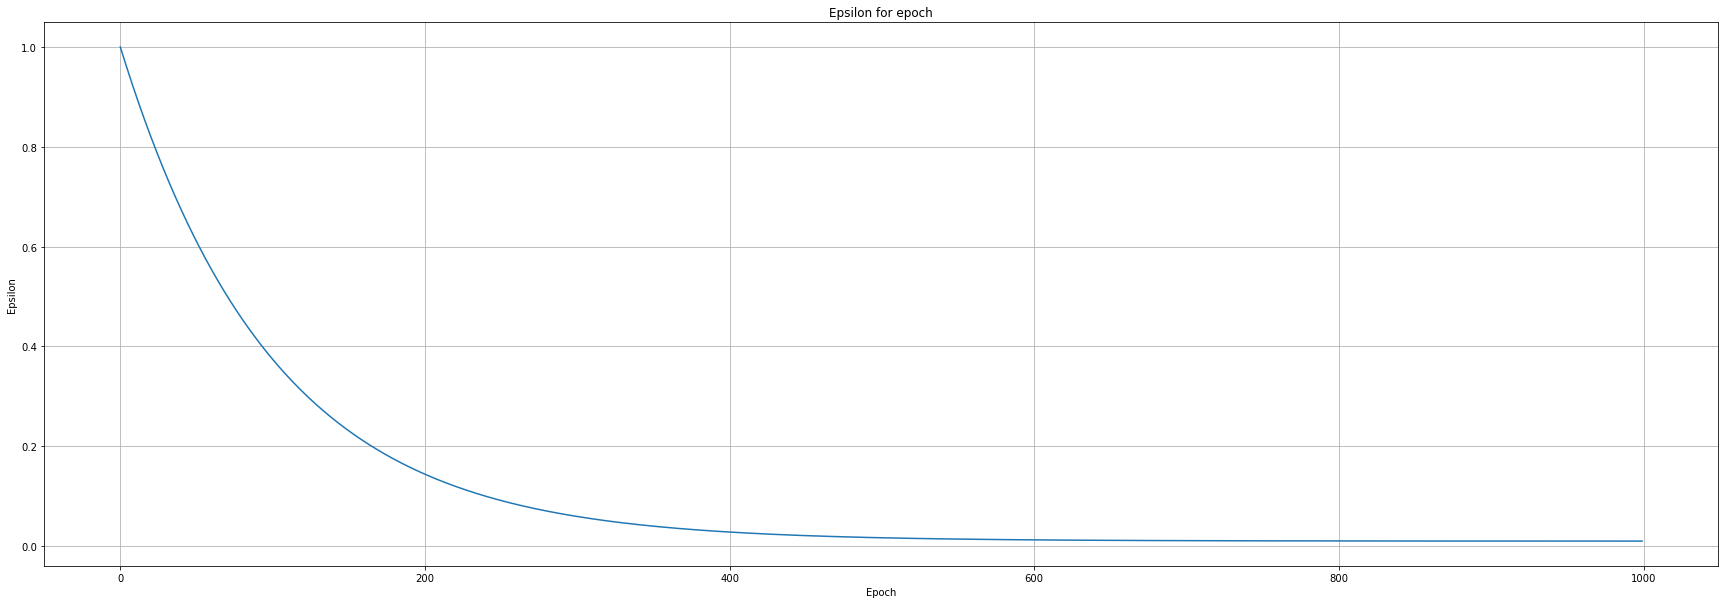

In [439]:
q_learning_1.plot_learning_process()
q_learning_1.plot_epsilons()

In [440]:
q_learning_1.evaluate(50, with_training=False)

After 50 evaluations:
Average time steps to finish: 2435
Average points per epoch: -9486


In [441]:
q_learning_1.evaluate(1, with_training=True)

After 1 evaluations:
Average time steps to finish: 14
Average points per epoch: 7


In [442]:
q_learning_1.show_map((3, 1, 2, 0), 50, with_training=False)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

Timestep: 50
State: 28
Action: 4
Reward: -10


In [443]:
q_learning_1.show_map((4, 4, 2, 0), 50, with_training=True)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Timestep: 50
State: 488
Action: 0
Reward: -1
